In [44]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.insert(0, '../src/')
import HR_OT
import toy_example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64


On device: cuda


# Hierarchical Refinement: Simple Demo (Faster)

This demo differs from the previous one in using a low-rank OT solver (LR_mini) which fixes $g$ to be uniform explicitly rather than implicitly and fewer internal steps. We also use squared-Euclidean cost ($c(x_{i}, y_{j}) = \lVert x_{i} - y_{j} \rVert_{2}^{2}$) in place of the Euclidean for this example.


# We'll first evaluate Refinement with a full-rank cost matrix $\mathbf{C}$

Refinement's default initialization can take in a full-cost, i.e. if one wants to specify an arbitrary, general cost functional defined entrywise as $\mathbf{C}_{ij} = c(\mathbf{x}_{i}, \mathbf{x}_{j} )$.


In [46]:

X1, X2 = toy_example.generate_sample_data(N = 8192)

X = torch.from_numpy(X1).type(torch.DoubleTensor).to(device)
Y = torch.from_numpy(X2).type(torch.DoubleTensor).to(device)
C = torch.cdist(X, Y)**2

n = X1.shape[0]

First, we call the rank-annealing scheduler to find a sequence of ranks which minimizes the number of calls of the low-rank optimal transport subroutine used, while remaining under a machine-specific maximal rank. The parameters include:

- n : The size of the dataset

- $\kappa$ or hierarchy\_depth : The depth of the hierarchy of levels used in the refinement strategy.

- max\_Q : The maximal terminal rank at the base case

- max\_rank : The maximal rank of the intermediate sub-problems

  

In [47]:
import rank_annealing

rank_schedule = rank_annealing.optimal_rank_schedule( n , hierarchy_depth = 6, max_Q = 2**10, max_rank = 2**10 )

Optimized rank-annealing schedule: [16, 512]


First, we evaluate and visualize the mapping output by Refinement using the full-rank cost $\mathbf{C}$


--- Rank Level 1 of 2 ---
---LR-OT Iteration: 0---

--- Rank Level 2 of 2 ---
>>> Final Rank Level | Rank Chunk Size: 512 | Remaining Iterations: 16
    Base-Level Iteration 1/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 2/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 3/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 4/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 5/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 6/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 7/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 8/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 9/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 10/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 11/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 12/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 13/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 14/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 15/16 
---LR-OT Iteration: 0---
    

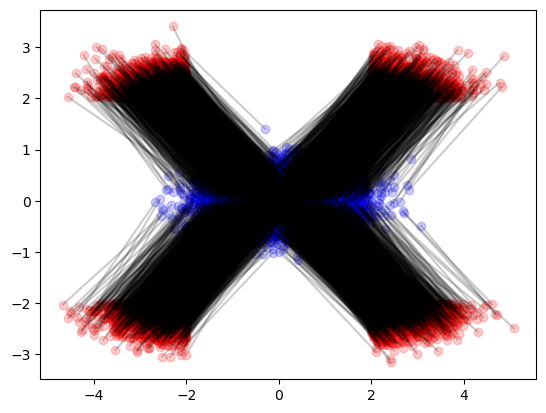

Refinement Cost: 8.126681325680664


In [48]:
import LR_mini

solver_params = {
            'gamma' : 90,
            'max_iter' : 14,
            'min_iter' : 10,
            'max_inneriters_balanced' : 60
        }

hrot = HR_OT.HierarchicalRefinementOT(C, rank_schedule,
                                      base_rank=1, device=device,
                                      solver_params=solver_params, 
                                      solver=LR_mini.LROT_opt)

F = hrot.run(return_as_coupling=False)

for pair in F:
    idx1, idx2 = pair
    idx1, idx2 = idx1.cpu().numpy(), idx2.cpu().numpy()
    x_values = X1[idx1, 0], X2[idx2, 0]
    y_values = X1[idx1, 1], X2[idx2, 1]
    plt.plot(x_values, y_values, c='black', alpha=0.2)

plt.scatter(X1[:,0], X1[:,1], c='b', label=r'Set A', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], c='r', label=r'Set B', alpha=0.2)

plt.show()

cost_hr_ot = hrot.compute_OT_cost()
print(f'Refinement Cost: { cost_hr_ot.item() }')

Next, we use init\_from\_point\_clouds to initialize the class using datasets $\mathbf{X}, \mathbf{Y}$ and run without initializing with a full-rank cost matrix. This ensures _linear_ space in both matrices, and is the variant used for scaling to massive datasets, e.g. ImageNet.


--- Rank Level 1 of 2 ---
---LR-OT Iteration: 0---

--- Rank Level 2 of 2 ---
>>> Final Rank Level | Rank Chunk Size: 512 | Remaining Iterations: 16
    Base-Level Iteration 1/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 2/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 3/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 4/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 5/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 6/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 7/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 8/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 9/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 10/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 11/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 12/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 13/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 14/16 
---LR-OT Iteration: 0---
    Base-Level Iteration 15/16 
---LR-OT Iteration: 0---
    

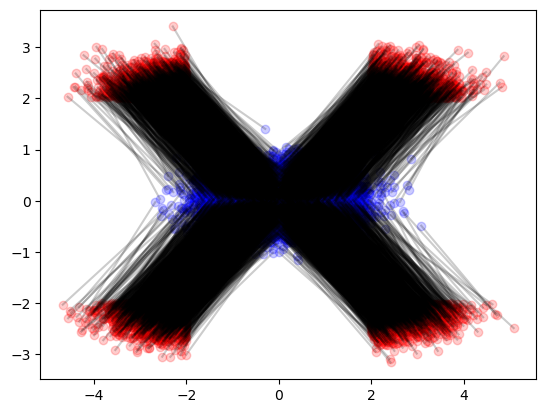

Refinement Cost: 8.130729981673985


In [49]:
import LR_mini
import HR_OT

solver_params = {
            'gamma' : 90,
            'max_iter' : 14,
            'min_iter' : 10,
            'max_inneriters_balanced' : 60
        }

hrot_lr = HR_OT.HierarchicalRefinementOT.init_from_point_clouds(X, Y,
                                                                rank_schedule, base_rank=1,
                                                                device=device,
                                                                solver_params=solver_params,
                                                                solver=LR_mini.LROT_LR_opt,
                                                                solver_full=LR_mini.LROT_opt,
                                                                sq_Euclidean=True)

F_lr = hrot_lr.run(return_as_coupling=False)

for pair in F_lr:
    idx1, idx2 = pair
    idx1, idx2 = idx1.cpu().numpy(), idx2.cpu().numpy()
    x_values = X1[idx1, 0], X2[idx2, 0]
    y_values = X1[idx1, 1], X2[idx2, 1]
    plt.plot(x_values, y_values, c='black', alpha=0.2)

plt.scatter(X1[:,0], X1[:,1], c='b', label=r'Set A', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], c='r', label=r'Set B', alpha=0.2)

plt.show()

cost_hr_ot = hrot_lr.compute_OT_cost()
print(f'Refinement Cost: { cost_hr_ot.item() }')

# Larger-scale example (2 x 200,000 points)

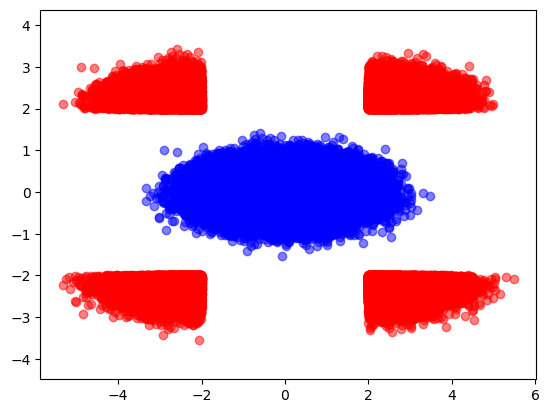

Optimized rank-annealing schedule: [200, 1000]
[200, 1000]

--- Rank Level 1 of 2 ---
---LR-OT Iteration: 0---

--- Rank Level 2 of 2 ---
>>> Final Rank Level | Rank Chunk Size: 1000 | Remaining Iterations: 200
    Base-Level Iteration 1/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 2/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 3/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 4/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 5/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 6/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 7/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 8/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 9/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 10/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 11/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 12/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 13/200 
---LR-OT Iteration: 0---
    Base-Level Iteration 14/200 
---LR-OT It

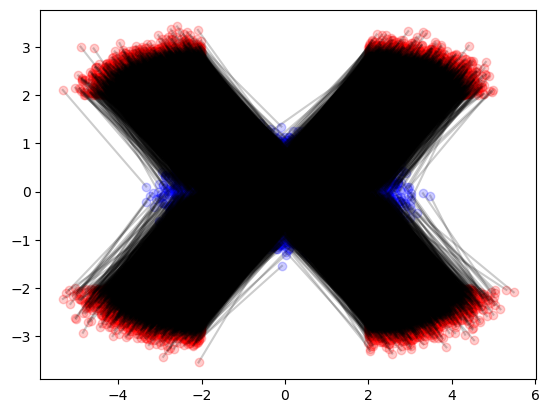

Refinement Cost: 8.067172850479169


In [51]:
import toy_example
import rank_annealing

X1, X2 = toy_example.generate_sample_data(N = 200000)
n = X1.shape[0]

X = torch.from_numpy(X1).type(torch.DoubleTensor).to(device)
Y = torch.from_numpy(X2).type(torch.DoubleTensor).to(device)

rank_schedule = rank_annealing.optimal_rank_schedule( n , hierarchy_depth = 6, max_Q = 2**10, max_rank = 2**10 )

print(rank_schedule)

solver_params = {
            'gamma' : 90,
            'max_iter' : 14,
            'min_iter' : 10,
            'max_inneriters_balanced' : 60
        }

hrot_lr = HR_OT.HierarchicalRefinementOT.init_from_point_clouds(X, Y,
                                                                rank_schedule, base_rank=1,
                                                                device=device,
                                                                solver_params=solver_params,
                                                                solver=LR_mini.LROT_LR_opt,
                                                                solver_full=LR_mini.LROT_opt,
                                                                sq_Euclidean=True)

F_lr = hrot_lr.run(return_as_coupling=False)

for pair in F_lr:
    idx1, idx2 = pair
    idx1, idx2 = idx1.cpu().numpy(), idx2.cpu().numpy()
    x_values = X1[idx1, 0], X2[idx2, 0]
    y_values = X1[idx1, 1], X2[idx2, 1]
    plt.plot(x_values, y_values, c='black', alpha=0.2)

plt.scatter(X1[:,0], X1[:,1], c='b', label=r'Set A', alpha=0.2)
plt.scatter(X2[:,0], X2[:,1], c='r', label=r'Set B', alpha=0.2)

plt.show()

cost_hr_ot = hrot_lr.compute_OT_cost()
print(f'Refinement Cost: { cost_hr_ot.item() }')
